# Business Analytics
## Quality of Classification
(C) 2021

In [24]:
from IPython.display import HTML, display

def optional_material():
    '''
    When run in a cell, this function will color the cell blue to indicate
    the material is optional
    '''
    script =  "var cell = this.closest('.code_cell');"
    script += "var editor = cell.querySelector('.input_area');"
    script += "editor.style.background='#bde4f0';"
    script += "this.parentNode.removeChild(this)"
    
    display(HTML(f'<img src onerror="{script}">'))
    
optional_material()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:900px !important; }</style>"))

# Tahoe Healthcare

### Load the data

In [25]:
import pandas as pd

df_tahoe = pd.read_excel('/Users/gujiajun/Downloads/tahoe data.xlsx')
df_tahoe.head()

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


### Initial analysis

In [26]:
currency_format = lambda x : '${:,.2f}'.format(x)

Problem data

In [27]:
# Penalty per re-admitted patient
readmit_penalty = 8000

# Cost of CareTracker per patient
caretracker_cost = 1200

# Percentage reduction in readmissions with CareTracker
readmit_reduction = 0.6

Status quo

In [28]:
# In the status quo, we would pay for all re-admitted
# patients
currency_format(readmit_penalty * df_tahoe.readmit30.sum())

'$7,984,000.00'

Implementing CareTracker for everyone

In [29]:
total_caretracker_cost = len(df_tahoe)*caretracker_cost
total_readmit_penalty = df_tahoe.readmit30.sum()*readmit_reduction*readmit_penalty

currency_format(total_caretracker_cost + total_readmit_penalty)

'$10,048,800.00'

### Cost matrix

In [30]:
cost_matrix = pd.DataFrame([[0,1200],[8000,6000]])
cost_matrix

,0,1
0,0,1200
1,8000,6000


Status quo

In [31]:
status_quo = pd.DataFrame([[(1-df_tahoe.readmit30).sum(), 0],[df_tahoe.readmit30.sum(), 0]])
status_quo

,0,1
0,3384,0
1,998,0


In [32]:
currency_format((cost_matrix*status_quo).sum().sum())

'$7,984,000.00'

Implementing CareTracker for everyone

In [33]:
all_caretracker = pd.DataFrame([[0, (1-df_tahoe.readmit30).sum()],[0, df_tahoe.readmit30.sum()]])
all_caretracker

,0,1
0,0,3384
1,0,998


In [34]:
currency_format((cost_matrix*all_caretracker).sum().sum())

'$10,048,800.00'

Best case scenario - we know exactly who needs CareTracker

In [35]:
best_case = pd.DataFrame([[(1-df_tahoe.readmit30).sum(), 0],[0, df_tahoe.readmit30.sum()]])
currency_format((cost_matrix*best_case).sum().sum())

'$5,988,000.00'

### A first classifier

In [36]:
print('Re-admitted patients')
print(df_tahoe[df_tahoe.readmit30 == 1]['severity score'].mean())
print(df_tahoe[df_tahoe.readmit30 == 1]['severity score'].std())

Re-admitted patients
30.672344689378757
20.579026841682253


In [37]:
print('NON re-admitted patients')
print(df_tahoe[df_tahoe.readmit30 == 0]['severity score'].mean())
print(df_tahoe[df_tahoe.readmit30 == 0]['severity score'].std())

NON re-admitted patients
19.89982269503546
16.388526875595662


### Evaluating the first classifier

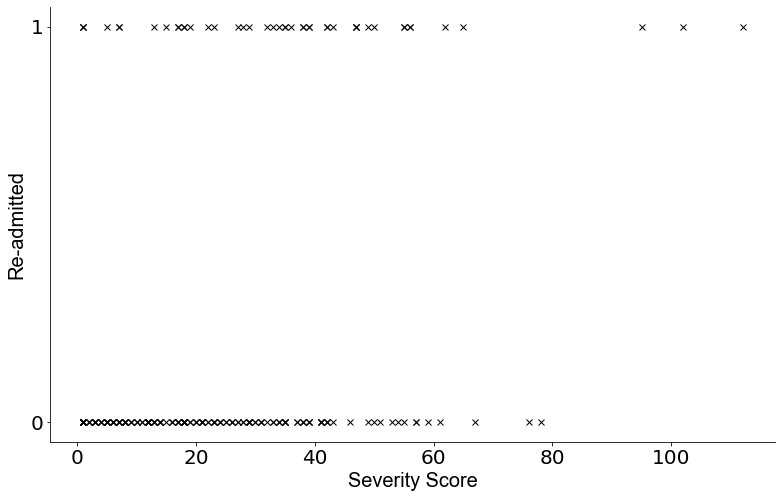

In [38]:
optional_material()

import matplotlib.pyplot as plt
import seaborn as sns

df_sub = df_tahoe.sample(frac=0.05, random_state=123)

plt.figure(figsize=(13, 8))
plt.plot(df_sub['severity score'], df_sub.readmit30, linewidth=0, marker='x', color='black')
plt.xlabel('Severity Score', fontfamily='Arial', fontsize=20)
plt.ylabel('Re-admitted', fontfamily='Arial', fontsize=20)
plt.yticks([0,1], fontsize=20)
plt.xticks(fontsize=20)
sns.despine()

In [39]:
true_positives = ((df_tahoe['severity score'] >= 25.5) & (df_tahoe.readmit30 == 1)).sum()
true_positives

546

In [40]:
false_negatives = ((df_tahoe['severity score'] < 25.5) & (df_tahoe.readmit30 == 1)).sum()
false_negatives

452

In [41]:
false_positives = ((df_tahoe['severity score'] >= 25.5) & (df_tahoe.readmit30 == 0)).sum()
false_positives

1041

In [42]:
true_negatives = ((df_tahoe['severity score'] < 25.5) & (df_tahoe.readmit30 == 0)).sum()
true_negatives

2343

### Confusion matrix

In [43]:
import sklearn.metrics as sk_m
confusion_matrix = sk_m.confusion_matrix(df_tahoe.readmit30, df_tahoe['severity score'] >= 25.5)
confusion_matrix

array([[2343, 1041],
       [ 452,  546]])

In [44]:
total_error_rate = (confusion_matrix[0,1] + confusion_matrix[1,0])/len(df_tahoe)
total_error_rate

0.3407120036513008

In [45]:
false_positive_rate = confusion_matrix[0,1]/(confusion_matrix[0,1] + confusion_matrix[0,0])
false_positive_rate

0.3076241134751773

In [46]:
true_positive_rate = confusion_matrix[1,1]/(confusion_matrix[1,0] + confusion_matrix[1,1])
true_positive_rate

0.5470941883767535

### Moving the threshold

In [47]:
import sklearn.metrics as sk_m
confusion_matrix = sk_m.confusion_matrix(df_tahoe.readmit30, df_tahoe['severity score'] >= 50.5)
confusion_matrix

array([[3190,  194],
       [ 826,  172]])

In [48]:
total_error_rate = (confusion_matrix[0,1] + confusion_matrix[1,0])/len(df_tahoe)
total_error_rate

0.2327704244637152

In [49]:
false_positive_rate = confusion_matrix[0,1]/(confusion_matrix[0,1] + confusion_matrix[0,0])
false_positive_rate

0.057328605200945626

In [50]:
true_positive_rate = confusion_matrix[1,1]/(confusion_matrix[1,0] + confusion_matrix[1,1])
true_positive_rate

0.17234468937875752

### The ROC curve

In [51]:
fpr, tpr, thresh = sk_m.roc_curve(df_tahoe.readmit30, df_tahoe['severity score'])

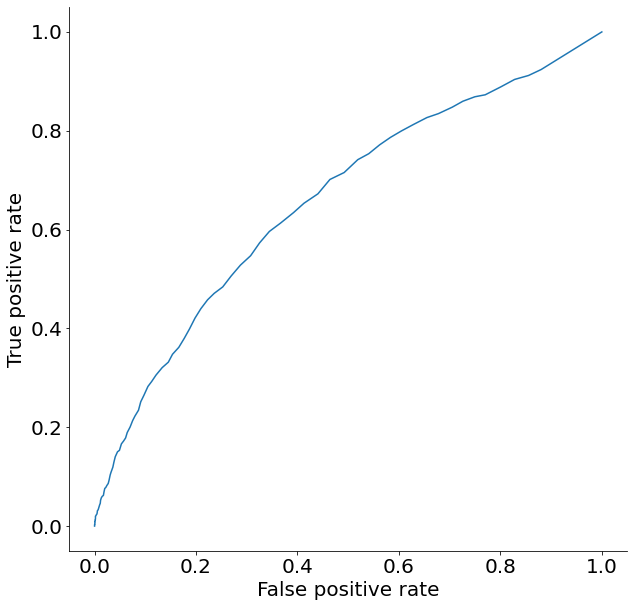

In [52]:
plt.figure(figsize=(10, 10))
plt.plot(fpr,tpr)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

### Economic tradeoffs in classification

In [53]:
currency_format((sk_m.confusion_matrix(df_tahoe.readmit30,
                                       df_tahoe['severity score'] >= 25.5)
                 *cost_matrix).sum().sum())

'$8,141,200.00'

In [54]:
currency_format((sk_m.confusion_matrix(df_tahoe.readmit30,
                                       df_tahoe['severity score'] >= 50.5)
                 *cost_matrix).sum().sum())

'$7,872,800.00'

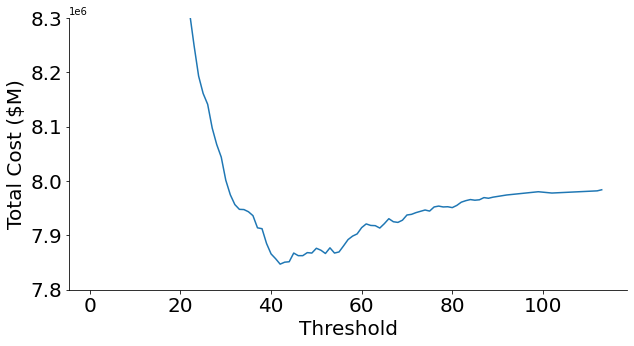

In [55]:
costs = []

for t in thresh:
    costs.append((sk_m.confusion_matrix(df_tahoe.readmit30,
                                        df_tahoe['severity score'] >= t)
                  *cost_matrix).sum().sum())

plt.figure(figsize=(10, 5))
plt.plot(thresh, costs)
plt.ylim([7.8*10**6, 8.3*10**6])
plt.xlabel('Threshold', fontsize=20)
plt.ylabel('Total Cost ($M)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.despine()

In [56]:
print(currency_format(min(costs)))
print(currency_format((cost_matrix*status_quo).sum().sum() - min(costs)))
print(thresh[costs.index(min(costs))])

$7,847,200.00
$136,800.00
42


### Logistic regression

In [57]:
seed = 123

In [58]:
import sklearn.linear_model as sk_lm
import sklearn.model_selection as sk_ms

X_cols = df_tahoe.columns[df_tahoe.columns != 'readmit30'].tolist()

df_train, df_test = sk_ms.train_test_split(df_tahoe,
                                           train_size=0.7,
                                           random_state=seed,
                                           shuffle=True)

lr = sk_lm.LogisticRegression(penalty='none')
lr.fit(df_train[X_cols], df_train.readmit30)

pd.DataFrame(zip(X_cols, lr.coef_[0]))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


,0,1
0,age,0.005275
1,female,0.239143
2,flu_season,0.744847
3,ed_admit,-0.106745
4,severity score,0.025642
5,comorbidity score,0.015323


In [59]:
# Add predictions to the training and test set; we need to copy
# the DataFrames because sk_ms.train_test_split doesn't necessary
# copy the data
df_train, df_test = df_train.copy(), df_test.copy()

df_train['lr_score'] = [i[1] for i in lr.predict_proba(df_train[X_cols])]
df_test['lr_score'] = [i[1] for i in lr.predict_proba(df_test[X_cols])]

In [60]:
df_train.head(2)

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30,lr_score
4021,79,1,1,1,14,150,1,0.422452
3152,80,0,1,1,57,96,1,0.432558


In [61]:
df_test.head(2)

,age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30,lr_score
4013,88,0,0,1,18,9,0,0.035324
3519,67,0,0,1,23,23,0,0.044139


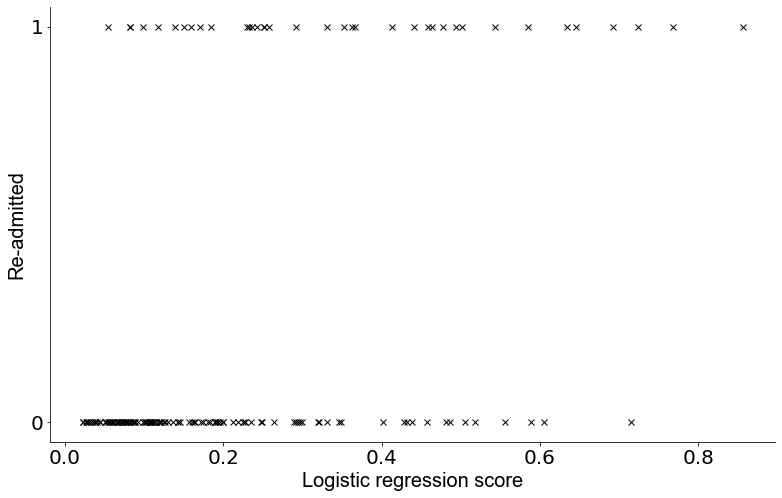

In [62]:
optional_material()

df_sub = df_train.sample(frac=0.05, random_state=123)

plt.figure(figsize=(13, 8))
plt.plot(df_sub.lr_score, df_sub.readmit30, linewidth=0, marker='x', color='black')
plt.xlabel('Logistic regression score', fontfamily='Arial', fontsize=20)
plt.ylabel('Re-admitted', fontfamily='Arial', fontsize=20)
plt.yticks([0,1], fontsize=20)
plt.xticks(fontsize=20)
sns.despine()

In [63]:
sk_m.confusion_matrix(df_train.readmit30,
                      df_train.lr_score >= 0.25)

array([[1798,  560],
       [ 248,  461]])

In [64]:
currency_format((sk_m.confusion_matrix(df_train.readmit30,
                                       df_train.lr_score >= 0.25)
                 *cost_matrix).sum().sum())

'$5,422,000.00'

In [65]:
# Find the best threshold based on the training set

costs_severity = []
costs_logistic = []

thresh_severity = sorted(df_train['severity score'].unique().tolist())
thresh_logistic = sorted(df_train.lr_score.unique().tolist())

for t in thresh_severity:
    costs_severity.append((sk_m.confusion_matrix(df_train.readmit30,
                                                 df_train['severity score'] >= t)
                          *cost_matrix).sum().sum())

for t in thresh_logistic:
    costs_logistic.append((sk_m.confusion_matrix(df_train.readmit30,
                                                 df_train.lr_score >= t)
                           *cost_matrix).sum().sum())

In [66]:
import numpy as np
optimal_threshold_severity = thresh_severity[np.argmin(costs_severity)]
print(optimal_threshold_severity)

44


In [67]:
optimal_threshold_logistic = thresh_logistic[np.argmin(costs_logistic)]
print(optimal_threshold_logistic)

0.3716567238649233


In [68]:
# See how well these thresholds do on the test set

status_quo_test = (pd.DataFrame([[(1-df_test.readmit30).sum(), 0],
                                 [df_test.readmit30.sum(), 0]])
                   *cost_matrix).sum().sum()

perfect_class_test = (pd.DataFrame([[(1-df_test.readmit30).sum(), 0],
                                    [0, df_test.readmit30.sum()]])
                     *cost_matrix).sum().sum()

severity_test = (sk_m.confusion_matrix(df_test.readmit30,
                                       df_test['severity score'] >= optimal_threshold_severity)
                 *cost_matrix).sum().sum()

logistic_test = (sk_m.confusion_matrix(df_test.readmit30,
                                       df_test.lr_score >= optimal_threshold_logistic)
                 *cost_matrix).sum().sum()

In [69]:
print('Perfect classification: ' + currency_format(status_quo_test - perfect_class_test))
print('Severity score classifier: ' + currency_format(status_quo_test - severity_test))
print('Logistic classifier: ' + currency_format(status_quo_test - logistic_test))
print()
print('% improvement in costs: ' + str(  np.round((status_quo_test - logistic_test)*100
                                        / status_quo_test, 2)) )
print('% of total value captured: ' + str( np.round((status_quo_test - logistic_test)*100
                                          /(status_quo_test - perfect_class_test), 2 )) )

Perfect classification: $578,000.00
Severity score classifier: $40,400.00
Logistic classifier: $144,800.00

% improvement in costs: 6.26
% of total value captured: 25.05


### The Area Under the Curve (AUC)

In [70]:
fpr_severity, tpr_severity, _ = sk_m.roc_curve(df_test.readmit30, df_test['severity score'])
fpr_logistic, tpr_logistic, _ = sk_m.roc_curve(df_test.readmit30, df_test.lr_score)

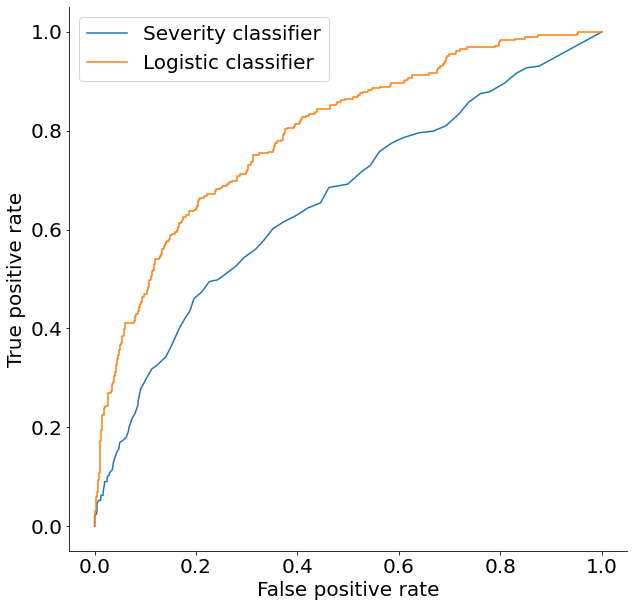

In [71]:
plt.figure(figsize=(10, 10))

plt.plot(fpr_severity,tpr_severity)
plt.plot(fpr_logistic,tpr_logistic)

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

plt.legend(['Severity classifier', 'Logistic classifier'], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

In [72]:
sk_m.roc_auc_score(df_test.readmit30, df_test['severity score'])

0.6585692412499915

In [73]:
sk_m.roc_auc_score(df_test.readmit30, df_test.lr_score)

0.7948157591209859

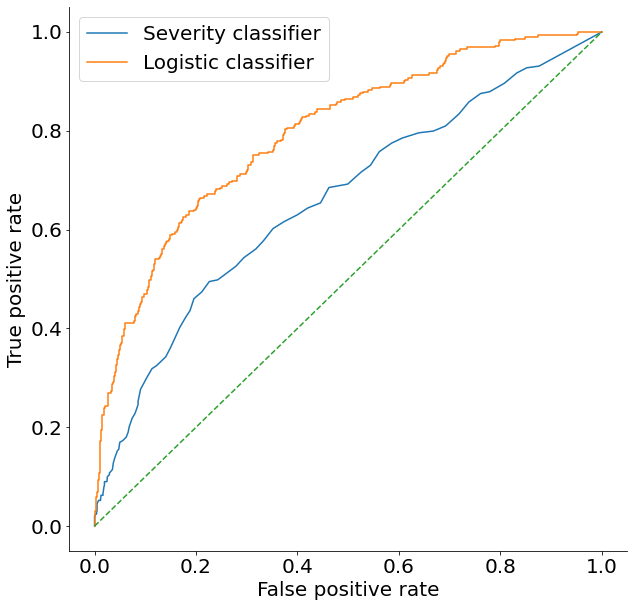

In [74]:
# Plot the ROC curves including the random model
plt.figure(figsize=(10, 10))

plt.plot(fpr_severity,tpr_severity)
plt.plot(fpr_logistic,tpr_logistic)
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

plt.legend(['Severity classifier', 'Logistic classifier'], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

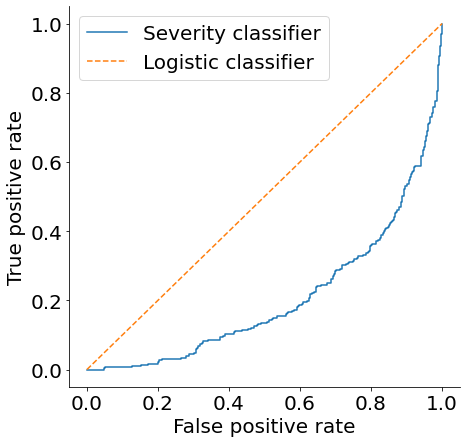

In [75]:
# Plot an ROC curve for an "inverted" model
fpr_wrong, tpr_wrong, _ = sk_m.roc_curve(df_test.readmit30, [1-i for i in df_test.lr_score])

plt.figure(figsize=(7,7))

plt.plot(fpr_wrong,tpr_wrong)
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

plt.legend(['Severity classifier', 'Logistic classifier'], fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

### The interpretation of the AUC

In [76]:
sk_m.roc_auc_score(df_test.readmit30, df_test.lr_score)

0.7948157591209859

In [77]:
outcomes = df_test.readmit30.tolist()
scores = df_test.lr_score.tolist()

n_correct = 0
n_wrong = 0

for i in range(len(outcomes)):
    for j in range(i+1, len(outcomes)):
        if outcomes[i] != outcomes[j]:
            if np.sign(outcomes[i] - outcomes[j]) == np.sign(scores[i] - scores[j]):
                n_correct += 1
            else:
                n_wrong += 1

print(n_correct/(n_correct+n_wrong))

0.7948157591209859
